### Vary dimension $p$
Vary the number of nodes $p$ and observe the error, bias, and time to run.
The number of samples scales with $(p+s) \log p$ for $s$ denoting the sparsity of the precision matrix.

In [1]:
from utils import *
from opt import *
from time import perf_counter
import pickle

from joblib import Parallel, delayed
import os

from sklearn.covariance import graphical_lasso

SEED = 10
SAVE = True
PATH = './results/vardim/'
N_CPUS = os.cpu_count()
np.random.seed(SEED)

os.environ["OMP_NUM_THREADS"] = str(N_CPUS)

## Auxiliary functions

In [2]:
def create_data(p, n, mean_deg, group_prop, psd_fact=.05, weighted_edges=True, w_range=(.5, 1)):
    Z = create_Z(p, group_prop)

    # Create graph
    edge_prob = mean_deg/(p-1)
    A_true = generate_connected_er(p, edge_prob)

    if weighted_edges:
        weights = np.random.uniform(w_range[0], w_range[1], size=A_true.shape)
        weights = np.tril(weights)
        A_true = (weights + weights.T) * A_true

    # Precision matrix as loaded adjacency
    max_eigenval = np.abs(la.eigvalsh(A_true)[0])
    Theta = (max_eigenval + psd_fact) * np.eye(p) + A_true

    # Create signals
    Sigma = la.inv(Theta)
    X = np.random.multivariate_normal(np.zeros(p), Sigma, n)
    Sigma_hat = X.T@X/n

    return Sigma_hat, Theta, Z


def compute_metric_err(Thetas_est, Thetas_true, n_exps, Zs=None, thr=.2, metric_type='err'):
    n_graphs = len(Thetas_est)
    n_samples = len(Thetas_est[0])

    metric = np.zeros((n_graphs, n_samples, n_exps))
    for i, Thetas in enumerate(Thetas_true):
        for j, Theta in enumerate(Thetas):
            p = Theta.shape[0]
            Theta_od = Theta*(1-np.eye(p))
            for k in range(n_exps):
            
                Theta_exps_od = Thetas_est[i][j][k]*(1-np.eye(p))

                if metric_type == 'err':
                    metric[i,j,k] = compute_frob_err(Theta_exps_od, Theta_od)
                elif metric_type == 'err-v2':
                    metric[i,j,k] = compute_frob_err(Theta_exps_od, Theta_od, pre_norm=True)
                elif metric_type == 'f1':
                    metric[i,j,k] = compute_f1_score(Theta_exps_od, Theta_od, thr)
                elif metric_type == 'bias':
                    mean_Theta = np.mean(mat2lowtri(np.abs(Theta_exps_od)))
                    metric[i,j,k] = compute_dp2(Theta_exps_od, Zs[i][j]) / mean_Theta if mean_Theta else 0
                elif metric_type == 'sqrt-bias':
                    mean_Theta = np.mean(mat2lowtri(np.abs(Theta_exps_od)))
                    metric[i,j,k] = np.sqrt(compute_dp2(Theta_exps_od, Zs[i][j])) / mean_Theta if mean_Theta else 0
                else:
                    raise ValueError('Unknown metric.')

    return metric

def plot_results(x_range, err, exps, y_label='Error', plot_f='semilogx', plt_args={},
                 save=False, file_name=None):

    mean_err = np.mean(err, axis=0)
    fig = plt.figure(figsize=(5,4))
    ax = fig.subplots()

    for i, exp in enumerate(exps):
        getattr(ax, plot_f)(x_range, mean_err[:,i], exp['fmt'], **plt_args, label=exp['leg'])

    ax.set_xlabel('Number of nodes')
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(True)
    fig.tight_layout()

    if save and file_name:
        plt.savefig(file_name)
        print('Fig save as:', file_name)


def plot_err_bias_results(err, bias, exps, plot_lines=True, x_label='Error',
                          y_label='Bias', save=False, file_name=None):
    mean_err = np.mean(err, axis=0)
    mean_bias = np.mean(bias, axis=0)

    fig = plt.figure(figsize=(5,4))
    ax = fig.subplots()
    for i, exp in enumerate(exps):
        if plot_lines:
            ax.loglog(mean_err[:,i], mean_bias[:,i], exp['fmt'], label=exp['leg'])
        else:
            ax.loglog(mean_err[:,i], mean_bias[:,i], exp['fmt'][0], label=exp['leg'],
                      linestyle='None')
    # Adding labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(True)
    fig.tight_layout()

    if save and file_name:
        plt.savefig(file_name)
        print('Fig save as:', file_name)

def get_n_samples(n_nodes, n_edges, times=1):
    return int((n_nodes + n_edges)*np.log(n_nodes) * times)

def get_mu1_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def get_mu2_value(n_nodes, times=1):
    return times * (n_nodes - 1)**2

def run_exp(g, dim_range, data_p, exps, verb=False):
    Thetas_true = []
    Thetas_est = []
    Zs = []
    runingtimes = np.zeros((len(dim_range), len(exps)))
    for i, p in enumerate(dim_range):

        print('Graph', g+1, 'Number of nodes:', p)

        n = get_n_samples(p, p*data_p['mean_deg'])
        Sigma_hat, Theta, Z = create_data(p, n, **data_p)
        Thetas_true.append(Theta)
        Zs.append(Z)

        Theta_od = Theta*(1-np.eye(p))

        Thetas_est_e = np.zeros((len(exps), p,p))
        for j, exp in enumerate(exps):
            args = exp['args'].copy()

            t_init = perf_counter()
            if exp['model'] == 'glasso':
                args['alpha'] = get_mu1_value(p, n, args['alpha'] )
                _, Theta_est = graphical_lasso(Sigma_hat, **args)
            elif exp['model'] == 'fair_flasso':
                args['mu1'] = get_mu1_value(p, n, args['mu1'] )
                args['mu2'] = get_mu2_value(p, args['mu2'] ) 
                Theta_est = FairGLASSO_fista(Sigma_hat, Z=Z, **args)
            
            runingtimes[i,j] = perf_counter() - t_init
            Thetas_est_e[j] = Theta_est

            Theta_est_od = Theta_est*(1-np.eye(p))
            err = compute_frob_err(Theta_est_od, Theta_od)
            bias = compute_dp2(Theta_est, Z) / np.mean(mat2lowtri(np.abs(Theta_est_od))) if np.mean(mat2lowtri(np.abs(Theta_est_od))) else 0
            bias_v2 = compute_dp2(Theta_est_od, Z) / np.mean(mat2lowtri(np.abs(Theta_est_od))) if np.mean(mat2lowtri(np.abs(Theta_est_od))) else 0

            if verb:
                print(f'\t{exp["leg"]}: Err: {err:.4f} | Bias: {bias:.5f} | Bias v2: {bias_v2:.5f} | Time: {runingtimes[i,j]:.4f}')

        Thetas_est.append(Thetas_est_e)
        
    return Thetas_est, Thetas_true, runingtimes, Zs


In [3]:
# Experiment params
num_trials =  50

# Graph parameters
data_p = {
    'mean_deg': 5,
    'weighted_edges': True,
    'w_range': (.5, 1),
    'psd_fact': .1,
    'group_prop': [.25, .75],
}

DIM_RANGE = [10, 50, 100, 150, 200, 300, 500, 1000]
num_params = len(DIM_RANGE)
verbose = False

## Experiment 1 - Swept on Mu2

In [4]:
PREC_TYPE = None

Exps = [
    {'model': 'glasso', 'args': {'alpha': .1, 'max_iter': 2000, 'tol': 1e-3}, 'fmt': 'v:', 'leg': 'GL'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 0, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o:', 'leg': 'FGL, 0'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 1, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o--', 'leg': 'FGL DP, 1'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 1, 'bias_type': 'nodewise', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 's--', 'leg': 'FGL NDP, 1'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 10, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o-', 'leg': 'FGL DP, 10'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 10, 'bias_type': 'nodewise', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 's-', 'leg': 'FGL NDP, 10'},

]

print('CPUs employed:', N_CPUS)
t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exp)
                                  (g, DIM_RANGE, data_p, Exps, verb=verbose) for g in range(num_trials))
ellapsed_t = (perf_counter()-t_init)/60
print(f'----- Solved in {ellapsed_t:.3f} minutes -----')


Thetas_est, Thetas_true, runingtimes, Zs = zip(*results)

CPUs employed: 64


Graph 11 Number of nodes: 50
Graph 5Graph 8 Number of nodes: 50
 Number of nodes: 50
Graph 10 Number of nodes: 50
Graph 2 Number of nodes: 50
Graph 1 Number of nodes: 50
Graph 4 Number of nodes: 50
Graph 13 Number of nodes: 50
Graph 19 Number of nodes: 50
Graph 6 Number of nodes: 50
Graph 21 Number of nodes: 50
Graph 14 Number of nodes: 50
Graph 12 Number of nodes: 50
Graph 17 Number of nodes: 50
Graph 28 Number of nodes: 50
Graph 3 Number of nodes: 50
Graph 20 Number of nodes: 50
Graph 18 Number of nodes: 50
Graph 22 Number of nodes: 50
Graph 30 Number of nodes: 50
Graph 32 Number of nodes: 50
Graph 15Graph 25 Number of nodes: 50
 Number of nodes: 50
Graph 23 Number of nodes: 50
Graph 26 Number of nodes: 50
Graph 29 Number of nodes: 50
Graph 7 Number of nodes: 50
Graph 33 Number of nodes: 50
Graph 16 Number of nodes: 50
Graph 27 Number of nodes: 50
Graph 37 Number of nodes: 50
Graph 24 Number of nodes: 50
Graph 39 Number of nodes: 50
GraphGraph 34 Number of nodes: 50
 35 Number of nod

/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.058e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.861e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.398e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.358e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 5 Number of nodes: 100
Graph 13 Number of nodes: 100


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.310e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.178e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.886e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.497e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 4 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.509e-03
  warnings.warn(


Graph 34 Number of nodes: 150
Graph 17 Number of nodes: 150
Graph 20 Number of nodes: 100
Graph 19 Number of nodes: 100
Graph 42 Number of nodes: 150
Graph 6 Number of nodes: 150
Graph 3 Number of nodes: 100
Graph 27 Number of nodes: 100
Graph 49 Number of nodes: 150
Graph 33 Number of nodes: 150
Graph 40 Number of nodes: 150
Graph 18 Number of nodes: 100
Graph 47 Number of nodes: 150
Graph 26 Number of nodes: 100
Graph 37 Number of nodes: 150
Graph 16 Number of nodes: 150
Graph 10 Number of nodes: 150
Graph 29 Number of nodes: 150
Graph 41 Number of nodes: 150
Graph 46 Number of nodes: 150
Graph 45 Number of nodes: 100
Graph 32 Number of nodes: 100
GraphGraph 44 Number of nodes: 150
 8 Number of nodes: 150
Graph 15 Number of nodes: 100
Graph 12 Number of nodes: 150
Graph 39 Number of nodes: 100
Graph 38 Number of nodes: 150
Graph 22 Number of nodes: 100
Graph 23 Number of nodes: 100
Graph 21 Number of nodes: 100
Graph 24 Number of nodes: 100
Graph 36 Number of nodes: 100
Graph 7 Numbe

/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.174e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.864e-03
  warnings.warn(


Graph 15 Number of nodes: 150
Graph 22 Number of nodes: 150
Graph 21 Number of nodes: 150
Graph 24 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.432e-03
  warnings.warn(


Graph 7 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.096e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.080e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.187e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.934e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 39 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.005e-03
  warnings.warn(


Graph 25 Number of nodes: 150
Graph 6 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.887e-03
  warnings.warn(


Graph 30 Number of nodes: 150
Graph 35 Number of nodes: 150
Graph 1 Number of nodes: 150
Graph 40 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.697e-03
  warnings.warn(


Graph 33 Number of nodes: 200
Graph 17 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.000e-03
  warnings.warn(


Graph 31 Number of nodes: 150
Graph 11 Number of nodes: 150
Graph 41 Number of nodes: 200
Graph 48 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.342e-03
  warnings.warn(


Graph 43 Number of nodes: 150
Graph 50 Number of nodes: 150
Graph 28 Number of nodes: 150
Graph 14 Number of nodes: 200
Graph 44 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.617e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.559e-03
  warnings.warn(


Graph 2 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.242e-03
  warnings.warn(


Graph 9 Number of nodes: 150
Graph 38 Number of nodes: 200
Graph 13 Number of nodes: 200
Graph 5 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.110e-02
  warnings.warn(


Graph 19 Number of nodes: 200
Graph 26 Number of nodes: 150
Graph 23 Number of nodes: 150
Graph 27 Number of nodes: 200
Graph 32 Number of nodes: 150
Graph 24 Number of nodes: 200
Graph 45 Number of nodes: 150
Graph 3 Number of nodes: 150
Graph 20 Number of nodes: 150
Graph 22 Number of nodes: 200
Graph 39 Number of nodes: 200
Graph 25 Number of nodes: 200
Graph 36 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.094e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.314e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.215e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.016e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 1 Number of nodes: 200
Graph 35 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.407e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.289e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.177e-03
  warnings.warn(


Graph 10 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.113e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.216e-03
  warnings.warn(


Graph 43 Number of nodes: 200
Graph 28 Number of nodes: 200
Graph 50 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.001e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.774e-03
  warnings.warn(


Graph 2 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.747e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.134e-03
  warnings.warn(


Graph 32 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.744e-03
  warnings.warn(


Graph 45 Number of nodes: 200
Graph 20 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.262e-03
  warnings.warn(


Graph 6 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.226e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.308e-03
  warnings.warn(


Graph 37 Number of nodes: 200
Graph 4 Number of nodes: 200
Graph 42 Number of nodes: 200
Graph 49 Number of nodes: 200
Graph 47 Number of nodes: 200
Graph 33 Number of nodes: 300
Graph 8 Number of nodes: 200
Graph 46 Number of nodes: 200
Graph 34 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.640e-03
  warnings.warn(


Graph 16 Number of nodes: 200
Graph 19 Number of nodes: 300
Graph 29 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.031e-03
  warnings.warn(


Graph 12 Number of nodes: 200
Graph 18 Number of nodes: 200
Graph 13 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.292e-03
  warnings.warn(


Graph 15 Number of nodes: 200
Graph 7 Number of nodes: 200
Graph 21 Number of nodes: 200
Graph 24 Number of nodes: 300
Graph 25 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.206e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.872e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.434e-03
  warnings.warn(


Graph 11 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.720e-03
  warnings.warn(


Graph 27 Number of nodes: 300
Graph 48 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.157e-03
  warnings.warn(


Graph 30 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.190e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.009e-02
  warnings.warn(


Graph 43 Number of nodes: 300
Graph 10 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.698e-03
  warnings.warn(


Graph 9 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.901e-03
  warnings.warn(


Graph 31 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.182e-03
  warnings.warn(


Graph 28 Number of nodes: 300
Graph 5 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.392e-03
  warnings.warn(


Graph 26 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.013e-03
  warnings.warn(


Graph 20 Number of nodes: 300
Graph 36 Number of nodes: 200
Graph 3 Number of nodes: 200
Graph 23 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.872e-03
  warnings.warn(


Graph 32 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.285e-03
  warnings.warn(


Graph 4 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.894e-03
  warnings.warn(


Graph 42 Number of nodes: 300
Graph 47 Number of nodes: 300
Graph 34 Number of nodes: 300
Graph 29 Number of nodes: 300
Graph 18 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.059e-03
  warnings.warn(


Graph 7 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.891e-03
  warnings.warn(


Graph 21 Number of nodes: 300
Graph 41 Number of nodes: 300
Graph 48 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.963e-03
  warnings.warn(


Graph 38 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.222e-03
  warnings.warn(


Graph 17 Number of nodes: 300
Graph 44 Number of nodes: 300
Graph 14 Number of nodes: 300
Graph 40 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.716e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.668e-03
  warnings.warn(


Graph 31 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.402e-03
  warnings.warn(


Graph 39 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.131e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.486e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.657e-03
  warnings.warn(


Graph 22 Number of nodes: 300
Graph 1 Number of nodes: 300
Graph 36 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.872e-03
  warnings.warn(


Graph 35 Number of nodes: 300
Graph 50 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.012e-03
  warnings.warn(


Graph 2 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.969e-03
  warnings.warn(


Graph 45 Number of nodes: 300
Graph 37 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.035e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.078e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.897e-03
  warnings.warn(


Graph 49 Number of nodes: 300
Graph 6 Number of nodes: 500
Graph 16 Number of nodes: 300
Graph 8 Number of nodes: 300
Graph 46 Number of nodes: 300
Graph 15 Number of nodes: 300
Graph 12 Number of nodes: 300
Graph 11 Number of nodes: 300
Graph 25 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.125e-02
  warnings.warn(


Graph 5 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.853e-03
  warnings.warn(


Graph 30 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.384e-03
  warnings.warn(


Graph 43 Number of nodes: 500
Graph 9 Number of nodes: 300
Graph 10 Number of nodes: 500
Graph 26 Number of nodes: 300
Graph 3 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.182e-02
  warnings.warn(


Graph 23 Number of nodes: 300
Graph 20 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.217e-03
  warnings.warn(


Graph 32 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.455e-03
  warnings.warn(


Graph 7 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.354e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.827e-03
  warnings.warn(


Graph 18 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.251e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.590e-03
  warnings.warn(


Graph 21 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.379e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.579e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.187e-03
  warnings.warn(


Graph 14 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.249e-03
  warnings.warn(


Graph 17 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.060e-02
  warnings.warn(


Graph 38 Number of nodes: 500
Graph 22 Number of nodes: 500
Graph 31 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.505e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.001e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.731e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.393e-02
  warnings.warn(


Graph 39 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.436e-03
  warnings.warn(


Graph 49 Number of nodes: 500
Graph 19 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.261e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.668e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.965e-03
  warnings.warn(


Graph 46 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.459e-03
  warnings.warn(


Graph 37 Number of nodes: 500
Graph 24 Number of nodes: 500
Graph 33 Number of nodes: 500
Graph 11 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.142e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.045e-02
  warnings.warn(


Graph 26 Number of nodes: 500
Graph 12 Number of nodes: 500
Graph 23 Number of nodes: 500
Graph 13 Number of nodes: 500
Graph 42 Number of nodes: 500
Graph 30 Number of nodes: 500
Graph 27 Number of nodes: 500
Graph 47 Number of nodes: 500
Graph 28 Number of nodes: 500
Graph 29 Number of nodes: 500
Graph 48 Number of nodes: 500
Graph 41 Number of nodes: 500
Graph 4 Number of nodes: 500
Graph 44 Number of nodes: 500
Graph 40 Number of nodes: 500
Graph 34 Number of nodes: 500
Graph 1 Number of nodes: 500
Graph 9 Number of nodes: 500
Graph 50 Number of nodes: 500
Graph 36 Number of nodes: 500
Graph 35 Number of nodes: 500
Graph 16 Number of nodes: 500
Graph 8 Number of nodes: 500
Graph 3 Number of nodes: 500
Graph 2 Number of nodes: 500
Graph 15 Number of nodes: 500
Graph 45 Number of nodes: 500
Graph 5 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.959e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.274e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.007e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.051e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 18 Number of nodes: 1000


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.676e-03
  warnings.warn(


Graph 6 Number of nodes: 1000


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.637e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.041e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.869e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.960e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 43 Number of nodes: 1000


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.026e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.695e-03
  warnings.warn(


Graph 25 Number of nodes: 1000
Graph 46 Number of nodes: 1000


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.289e-02
  warnings.warn(


Graph 33 Number of nodes: 1000


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.037e-02
  warnings.warn(


Graph 24 Number of nodes: 1000


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.388e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.037e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.047e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.243e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 29 Number of nodes: 1000


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.220e-03
  warnings.warn(


Graph 38 Number of nodes: 1000


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.223e-03
  warnings.warn(


Graph 48 Number of nodes: 1000
Graph 1 Number of nodes: 1000
Graph 47 Number of nodes: 1000


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.198e-03
  warnings.warn(


Graph 32 Number of nodes: 1000
Graph 21 Number of nodes: 1000
Graph 27 Number of nodes: 1000


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.220e-03
  warnings.warn(


Graph 40 Number of nodes: 1000
Graph 35 Number of nodes: 1000
Graph 12 Number of nodes: 1000
Graph 16 Number of nodes: 1000
Graph 7 Number of nodes: 1000
Graph 5 Number of nodes: 1000
Graph 14 Number of nodes: 1000
Graph 11 Number of nodes: 1000
Graph 19 Number of nodes: 1000
Graph 17 Number of nodes: 1000
Graph 50 Number of nodes: 1000
Graph 31 Number of nodes: 1000
Graph 36 Number of nodes: 1000
Graph 10 Number of nodes: 1000
Graph 49 Number of nodes: 1000
Graph 26 Number of nodes: 1000
Graph 28 Number of nodes: 1000
Graph 41 Number of nodes: 1000
Graph 4 Number of nodes: 1000
Graph 44 Number of nodes: 1000
Graph 20 Number of nodes: 1000
Graph 8 Number of nodes: 1000
Graph 3 Number of nodes: 1000
Graph 37 Number of nodes: 1000
Graph 22 Number of nodes: 1000
Graph 39 Number of nodes: 1000
Graph 13 Number of nodes: 1000
Graph 30 Number of nodes: 1000
Graph 23 Number of nodes: 1000
Graph 34 Number of nodes: 1000
Graph 9 Number of nodes: 1000
Graph 2 Number of nodes: 1000
Graph 42 Number

/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.188e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.743e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.776e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.926e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

----- Solved in 32932.380 seconds -----


### Save reulst and compute errors

In [8]:
frob_err = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=None, thr=.2, metric_type='err')
f1_score = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=None, thr=.2, metric_type='f1')
bias = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=Zs, thr=.2, metric_type='bias')
sqrt_bias = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=Zs, thr=.2, metric_type='sqrt-bias')

if SAVE:
    graphs_file_name = PATH + f'vardim_graphs_mu2vals.pkl'
    data = {
        'Exps': Exps,
        'DIM_RANGE': DIM_RANGE,
        'Thetas_est': Thetas_est, 
        'Thetas_true': Thetas_true,
        'runingtimes': runingtimes,
        'Zs': Zs,
    }
    with open(graphs_file_name, 'wb') as f:
        pickle.dump(data, f)
        print('GRAPHS SAVED AS:', graphs_file_name)

    perfs_file_name = PATH + f'vardim_perf_mu2vals'
    np.savez(perfs_file_name, frob_err=frob_err, f1_score=f1_score,
             sqrt_bias=sqrt_bias, bias=bias)
    print('PERFORMANCE SAVED AS:', perfs_file_name)

GRAPHS SAVED AS: ./results/vardim/vardim_graphs_mu2vals.pkl
PERFORMANCE SAVED AS: ./results/vardim/vardim_perf_mu2vals


### Plot results

Fig save as: ./results/vardim/vardim_mu2vals_plt_err
Fig save as: ./results/vardim/vardim_mu2vals_plt_sqrtbias
Fig save as: ./results/vardim/vardim_mu2vals_plt_err-sqrtbias
Fig save as: ./results/vardim/vardim_mu2vals_plt_bias
Fig save as: ./results/vardim/vardim_mu2vals_plt_err-bias
Fig save as: ./results/vardim/vardim_mu2vals_plt_time


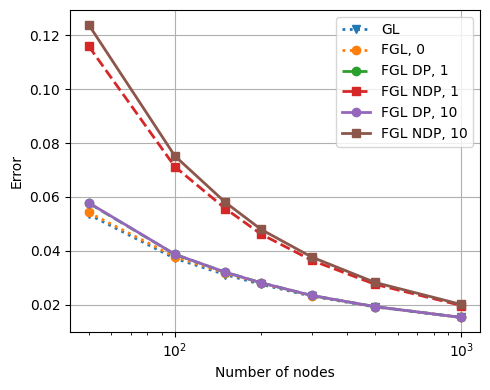

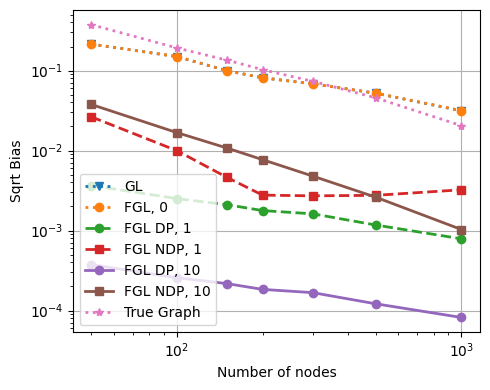

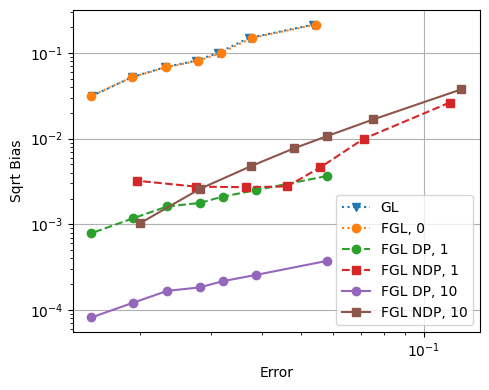

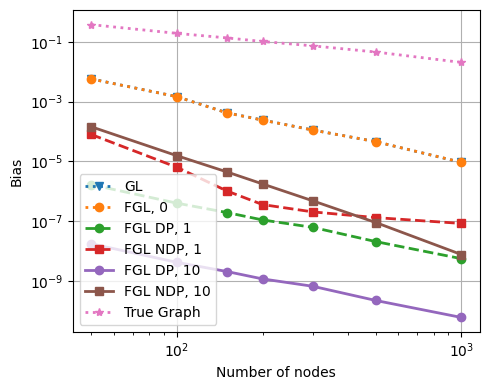

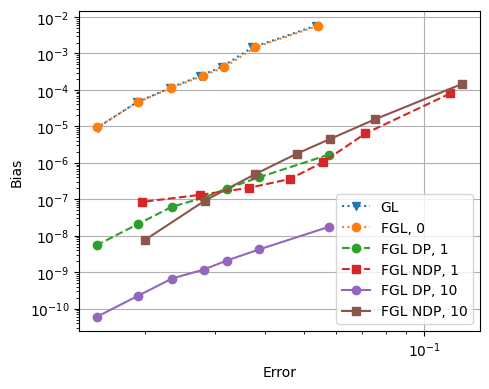

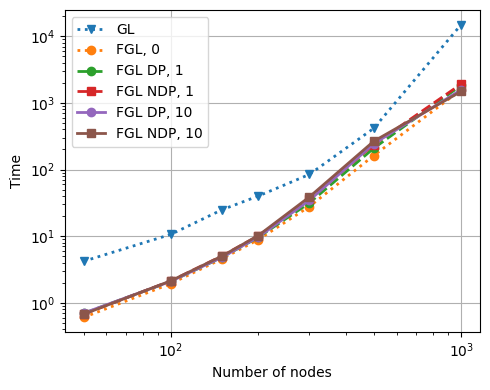

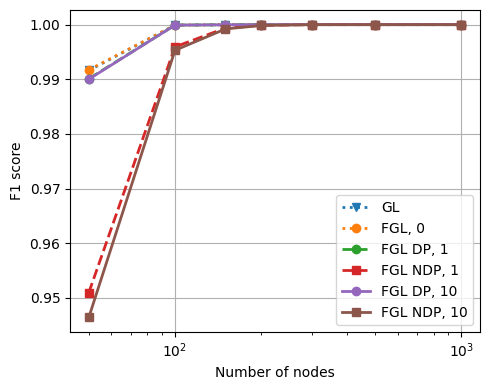

In [44]:
# Including bias from true graph
true_bias = compute_metric_err(Thetas_true, Thetas_true, 1, Zs=Zs, thr=.2, metric_type='bias')
true_sqrt_bias = compute_metric_err(Thetas_true, Thetas_true, 1, Zs=Zs, thr=.2, metric_type='sqrt-bias')
true_exp = {'fmt': '*:', 'leg': 'True Graph'}
Exps_aux =  Exps + [true_exp]
bias_aux = np.concatenate((bias, true_bias), axis=2)
sqrt_bias_aux = np.concatenate((sqrt_bias, true_bias), axis=2)

plt_args = { 'linewidth': 2 }
plot_results(DIM_RANGE, frob_err, Exps, y_label='Error', plt_args=plt_args, save=SAVE,
             file_name=f'{PATH}vardim_mu2vals_plt_err')
plot_results(DIM_RANGE, sqrt_bias_aux, Exps_aux, y_label='Sqrt Bias', plt_args=plt_args, plot_f='loglog', 
             save=SAVE, file_name=f'{PATH}vardim_mu2vals_plt_sqrtbias')
plot_err_bias_results(frob_err, sqrt_bias, Exps, plot_lines=True, y_label='Sqrt Bias',save=SAVE,
                      file_name=f'{PATH}vardim_mu2vals_plt_err-sqrtbias')

plot_results(DIM_RANGE, bias_aux, Exps_aux, y_label='Bias', plt_args=plt_args, plot_f='loglog',
             save=SAVE, file_name=f'{PATH}vardim_mu2vals_plt_bias')
plot_err_bias_results(frob_err, bias, Exps, plot_lines=True, save=SAVE,
                      file_name=f'{PATH}vardim_mu2vals_plt_err-bias')

plot_results(DIM_RANGE, runingtimes, Exps, y_label='Time', plt_args=plt_args, plot_f='loglog',
             save=SAVE, file_name=f'{PATH}vardim_mu2vals_plt_time')
plot_results(DIM_RANGE, f1_score, Exps, y_label='F1 score', plt_args=plt_args)

In [4]:
# # Load data
# file_name = PATH + 'vardim_graphs_mu2vals.pkl'
# with open(file_name, 'rb') as f:
#     data = pickle.load(f)

# Exps = data['Exps']
# Thetas_est = data['Thetas_est']
# Thetas_true = data['Thetas_true']
# runingtimes = data['runingtimes']
# Zs = data['Zs']

## Experiment 2 - Nonnegative projection

In [8]:

Exps = [
    # Unfair models
    {'model': 'glasso', 'args': {'alpha': .1, 'max_iter': 1000, 'tol': 1e-3}, 'fmt': 'v:', 'leg': 'GL'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 0, 'bias_type': 'dp', 
     'prec_type': None, 'EARLY_STOP': True}, 'fmt': 'o:', 'leg': 'GL'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 5, 'bias_type': 'dp', 
     'prec_type': None, 'EARLY_STOP': True}, 'fmt': 'o-', 'leg': 'FGL DP'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 5, 'bias_type': 'nodewise', 
     'prec_type': None, 'EARLY_STOP': True}, 'fmt': 'o--', 'leg': 'FGL NDP'},

    
    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 0, 'bias_type': 'dp', 
     'prec_type': 'non-negative', 'EARLY_STOP': True}, 'fmt': 's:', 'leg': 'GL Proj'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 5, 'bias_type': 'dp', 
     'prec_type': 'non-negative', 'EARLY_STOP': True}, 'fmt': 's-', 'leg': 'FGL DP Proj'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 5, 'bias_type': 'nodewise', 
     'prec_type': 'non-negative', 'EARLY_STOP': True}, 'fmt': 's--', 'leg': 'FGL NDP Proj'},
]

print('CPUs employed:', N_CPUS)
t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exp)
                                  (g, DIM_RANGE, data_p, Exps, verb=verbose) for g in range(num_trials))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3f} seconds -----')


Thetas_est, Thetas_true, runingtimes, Zs = zip(*results)

CPUs employed: 64


Graph 1 Number of nodes: 50
Graph 1 Number of nodes: 100
Graph 2 Number of nodes: 50
Graph 3 Number of nodes: 50
Graph 4 Number of nodes: 50
Graph 5 Number of nodes: 50
Graph 6 Number of nodes: 50
Graph 10 Number of nodes: 50
Graph 41 Number of nodes: 50
Graph 15 Number of nodes: 50
Graph 14 Number of nodes: 50
Graph 22 Number of nodes: 50
Graph 31 Number of nodes: 50
Graph 21 Number of nodes: 50
Graph 29 Number of nodes: 50
Graph 8 Number of nodes: 50
Graph 48 Number of nodes: 50
Graph 7 Number of nodes: 50
Graph 20 Number of nodes: 50
Graph 39 Number of nodes: 50
Graph 13 Number of nodes: 50
Graph 12 Number of nodes: 50
Graph 11 Number of nodes: 50
Graph 47 Number of nodes: 50
Graph 46 Number of nodes: 50
Graph 40 Number of nodes: 50
Graph 50 Number of nodes: 50
Graph 9 Number of nodes: 50
Graph 23 Number of nodes: 50
Graph 24 Number of nodes: 50
Graph 16 Number of nodes: 50
Graph 33 Number of nodes: 50
GraphGraph 17 Number of nodes: 50
 18 Number of nodes: 50
GraphGraph 28 Number of

/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.950e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.505e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.676e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.825e-03
  warnings.warn(


Graph 1 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.565e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.043e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.614e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.616e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 3 Number of nodes: 100
Graph 2 Number of nodes: 100
Graph 5 Number of nodes: 100


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.360e-03
  warnings.warn(


Graph 14 Number of nodes: 100
Graph 15 Number of nodes: 100
Graph 10 Number of nodes: 100
Graph 31 Number of nodes: 100
Graph 29 Number of nodes: 100


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.156e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.572e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.585e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.467e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 41 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.323e-03
  warnings.warn(


Graph 46 Number of nodes: 150
Graph 24 Number of nodes: 100


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.136e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.516e-03
  warnings.warn(


Graph 47 Number of nodes: 100
Graph 36 Number of nodes: 150
Graph 4 Number of nodes: 100
Graph 18 Number of nodes: 100
Graph 39 Number of nodes: 100
Graph 21 Number of nodes: 100
Graph 37 Number of nodes: 100
Graph 49 Number of nodes: 100
Graph 34 Number of nodes: 100
Graph 22 Number of nodes: 150
Graph 43 Number of nodes: 150
Graph 6 Number of nodes: 150
Graph 12 Number of nodes: 100
Graph 13 Number of nodes: 150
Graph 28 Number of nodes: 100
Graph 7 Number of nodes: 150
Graph 48 Number of nodes: 150
Graph 33 Number of nodes: 150
Graph 40 Number of nodes: 150
Graph 19 Number of nodes: 150
Graph 20 Number of nodes: 150
Graph 23 Number of nodes: 150
Graph 35 Number of nodes: 150
Graph 44 Number of nodes: 150
Graph 38 Number of nodes: 150
Graph 30 Number of nodes: 150
Graph 26 Number of nodes: 150
Graph 2 Number of nodes: 150
Graph 29 Number of nodes: 150
Graph 14 Number of nodes: 150
Graph 10 Number of nodes: 150
Graph 47 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.640e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.766e-03
  warnings.warn(


Graph 4 Number of nodes: 150
Graph 18 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.997e-03
  warnings.warn(


Graph 37 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.251e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.719e-03
  warnings.warn(


Graph 39 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.956e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.476e-03
  warnings.warn(


Graph 28 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.132e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.526e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.616e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.282e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 50 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.295e-03
  warnings.warn(


Graph 5 Number of nodes: 150
Graph 15 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.243e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.935e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.946e-03
  warnings.warn(


Graph 9 Number of nodes: 150
Graph 31 Number of nodes: 150
Graph 17 Number of nodes: 150
Graph 29 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.831e-03
  warnings.warn(


Graph 42 Number of nodes: 150
Graph 32 Number of nodes: 150
Graph 27 Number of nodes: 150
Graph 45 Number of nodes: 150
Graph 30 Number of nodes: 200
Graph 3 Number of nodes: 150
Graph 25 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.033e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.942e-03
  warnings.warn(


Graph 16 Number of nodes: 150
Graph 40 Number of nodes: 200
Graph 43 Number of nodes: 200
Graph 47 Number of nodes: 200
Graph 7 Number of nodes: 200
Graph 34 Number of nodes: 150
Graph 6 Number of nodes: 200
Graph 8 Number of nodes: 150
Graph 44 Number of nodes: 200
Graph 11 Number of nodes: 150
Graph 38 Number of nodes: 200
Graph 48 Number of nodes: 200
Graph 24 Number of nodes: 150
Graph 26 Number of nodes: 200
Graph 20 Number of nodes: 200
Graph 12 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.044e-02
  warnings.warn(


Graph 14 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.974e-03
  warnings.warn(


Graph 49 Number of nodes: 150
Graph 4 Number of nodes: 200
Graph 21 Number of nodes: 150


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.497e-03
  warnings.warn(


Graph 5 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.733e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.315e-02
  warnings.warn(


Graph 39 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.214e-03
  warnings.warn(


Graph 50 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.500e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.326e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.929e-03
  warnings.warn(


Graph 9 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.194e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.321e-03
  warnings.warn(


Graph 17 Number of nodes: 200
Graph 1 Number of nodes: 200
Graph 15 Number of nodes: 200
Graph 16 Number of nodes: 200
Graph 32 Number of nodes: 200
Graph 8 Number of nodes: 200
Graph 42 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.305e-03
  warnings.warn(


Graph 27 Number of nodes: 200
Graph 25 Number of nodes: 200
Graph 3 Number of nodes: 200
Graph 34 Number of nodes: 200
Graph 24 Number of nodes: 200
Graph 13 Number of nodes: 200
Graph 11 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.678e-03
  warnings.warn(


Graph 2 Number of nodes: 200
Graph 12 Number of nodes: 200


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.635e-03
  warnings.warn(


Graph 10 Number of nodes: 200
Graph 23 Number of nodes: 200
Graph 41 Number of nodes: 200
Graph 37 Number of nodes: 200
Graph 33 Number of nodes: 200
Graph 18 Number of nodes: 200
Graph 36 Number of nodes: 200
Graph 46 Number of nodes: 200
Graph 30 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.111e-02
  warnings.warn(


Graph 19 Number of nodes: 200
Graph 22 Number of nodes: 200
Graph 35 Number of nodes: 200
Graph 7 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.945e-03
  warnings.warn(


Graph 44 Number of nodes: 300
Graph 45 Number of nodes: 200
Graph 26 Number of nodes: 300
Graph 1 Number of nodes: 300
Graph 6 Number of nodes: 300
Graph 43 Number of nodes: 300
Graph 28 Number of nodes: 200
Graph 20 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 3.559e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.030e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.740e-03
  warnings.warn(


Graph 9 Number of nodes: 300
Graph 50 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.005e-03
  warnings.warn(


Graph 31 Number of nodes: 200
Graph 17 Number of nodes: 300
Graph 16 Number of nodes: 300
Graph 14 Number of nodes: 300
Graph 39 Number of nodes: 300
Graph 8 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.296e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.077e-02
  warnings.warn(


Graph 21 Number of nodes: 200
Graph 25 Number of nodes: 300
Graph 15 Number of nodes: 300
Graph 24 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.804e-03
  warnings.warn(


Graph 34 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.322e-03
  warnings.warn(


Graph 13 Number of nodes: 300
Graph 27 Number of nodes: 300
Graph 41 Number of nodes: 300
Graph 12 Number of nodes: 300
Graph 49 Number of nodes: 200
Graph 11 Number of nodes: 300
Graph 29 Number of nodes: 300
Graph 18 Number of nodes: 300
Graph 22 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.197e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.297e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.982e-03
  warnings.warn(


Graph 36 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.460e-03
  warnings.warn(


Graph 19 Number of nodes: 300
Graph 33 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.490e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.231e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.122e-03
  warnings.warn(


Graph 32 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.413e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.422e-02
  warnings.warn(


Graph 5 Number of nodes: 300
Graph 31 Number of nodes: 300
Graph 47 Number of nodes: 300


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.839e-03
  warnings.warn(


Graph 48 Number of nodes: 300
Graph 21 Number of nodes: 300
Graph 40 Number of nodes: 300
Graph 4 Number of nodes: 300
Graph 49 Number of nodes: 300
Graph 38 Number of nodes: 300
Graph 45 Number of nodes: 300
Graph 3 Number of nodes: 300
Graph 23 Number of nodes: 300
Graph 2 Number of nodes: 300
Graph 37 Number of nodes: 300
Graph 10 Number of nodes: 300
Graph 42 Number of nodes: 300
Graph 20 Number of nodes: 500
Graph 35 Number of nodes: 300
Graph 46 Number of nodes: 300
Graph 28 Number of nodes: 300
Graph 6 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.992e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.303e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.431e-03
  warnings.warn(


Graph 44 Number of nodes: 500
Graph 30 Number of nodes: 500
Graph 16 Number of nodes: 500
Graph 1 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.228e-02
  warnings.warn(


Graph 24 Number of nodes: 500
Graph 14 Number of nodes: 500
Graph 34 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 9.276e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.860e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.116e-03
  warnings.warn(


Graph 11 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.317e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.121e-03
  warnings.warn(


Graph 26 Number of nodes: 500
Graph 41 Number of nodes: 500
Graph 32 Number of nodes: 500
Graph 18 Number of nodes: 500
Graph 36 Number of nodes: 500
Graph 29 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.233e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.110e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 8.498e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.971e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 19 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.966e-03
  warnings.warn(


Graph 5 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.452e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.791e-03
  warnings.warn(


Graph 21 Number of nodes: 500
Graph 31 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.126e-03
  warnings.warn(


Graph 23 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.956e-03
  warnings.warn(


Graph 45 Number of nodes: 500
Graph 10 Number of nodes: 500
Graph 43 Number of nodes: 500
Graph 35 Number of nodes: 500
Graph 40 Number of nodes: 500
Graph 37 Number of nodes: 500
Graph 42 Number of nodes: 500
Graph 46 Number of nodes: 500
Graph 28 Number of nodes: 500
Graph 9 Number of nodes: 500
Graph 27 Number of nodes: 500
Graph 7 Number of nodes: 500
Graph 50 Number of nodes: 500
Graph 39 Number of nodes: 500
Graph 17 Number of nodes: 500
Graph 15 Number of nodes: 500
Graph 33 Number of nodes: 500
Graph 25 Number of nodes: 500
Graph 22 Number of nodes: 500
Graph 4 Number of nodes: 500
Graph 8 Number of nodes: 500
Graph 38 Number of nodes: 500
Graph 49 Number of nodes: 500
Graph 13 Number of nodes: 500
Graph 47 Number of nodes: 500
Graph 12 Number of nodes: 500
Graph 2 Number of nodes: 500
Graph 48 Number of nodes: 500
Graph 3 Number of nodes: 500


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.619e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.193e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.184e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 5.253e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 20 Number of nodes: 1000


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.293e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 7.101e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.402e-02
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.474e-03
  warnings.warn(
/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: Converge

Graph 24 Number of nodes: 1000
Graph 11 Number of nodes: 1000
Graph 16 Number of nodes: 1000
Graph 37 Number of nodes: 1000
Graph 6 Number of nodes: 1000
Graph 9 Number of nodes: 1000
Graph 23 Number of nodes: 1000
Graph 10 Number of nodes: 1000
Graph 33 Number of nodes: 1000
Graph 41 Number of nodes: 1000
Graph 27 Number of nodes: 1000
Graph 34 Number of nodes: 1000
Graph 19 Number of nodes: 1000
Graph 49 Number of nodes: 1000
Graph 22 Number of nodes: 1000
Graph 14 Number of nodes: 1000
Graph 38 Number of nodes: 1000
Graph 4 Number of nodes: 1000
Graph 42 Number of nodes: 1000
Graph 17 Number of nodes: 1000
Graph 44 Number of nodes: 1000
Graph 50 Number of nodes: 1000
Graph 39 Number of nodes: 1000
Graph 28 Number of nodes: 1000
Graph 46 Number of nodes: 1000
Graph 5 Number of nodes: 1000
Graph 1 Number of nodes: 1000
Graph 7 Number of nodes: 1000
Graph 8 Number of nodes: 1000
Graph 26 Number of nodes: 1000
Graph 32 Number of nodes: 1000
Graph 30 Number of nodes: 1000
Graph 29 Number

### Save reulst and compute errors

In [ ]:
frob_err = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=None, thr=.2, metric_type='err')
f1_score = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=None, thr=.2, metric_type='f1')
bias = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=Zs, thr=.2, metric_type='bias')
sqrt_bias = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=Zs, thr=.2, metric_type='sqrt-bias')

if SAVE:
    file_name = PATH + f'vardim_graphs_proj.pkl'
    data = {
        'Exps': Exps,
        'DIM_RANGE': DIM_RANGE,
        'Thetas_est': Thetas_est, 
        'Thetas_true': Thetas_true,
        'runingtimes': runingtimes,
        'Zs': Zs,
    }
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)
        print('DATA SAVED AS:', file_name)

    perfs_file_name = PATH + f'vardim_perf_proj'
    np.savez(perfs_file_name, frob_err=frob_err, f1_score=f1_score,
             sqrt_bias=sqrt_bias, bias=bias)
    print('PERFORMANCE SAVED AS:', perfs_file_name)

DATA SAVED AS: ./results/vardim/vardim_graphs_None_v2.pkl


### Plot results

Fig save as: ./results/vardim/vardim_proj_plt_err
Fig save as: ./results/vardim/vardim_proj_plt_sqrtbias
Fig save as: ./results/vardim/vardim_proj_plt_err-sqrtbias
Fig save as: ./results/vardim/vardim_proj_plt_bias
Fig save as: ./results/vardim/vardim_proj_plt_err-bias
Fig save as: ./results/vardim/vardim_proj_plt_time


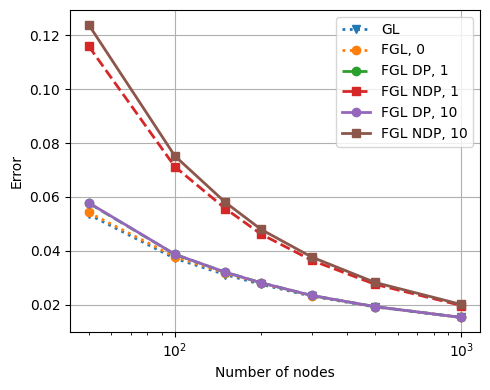

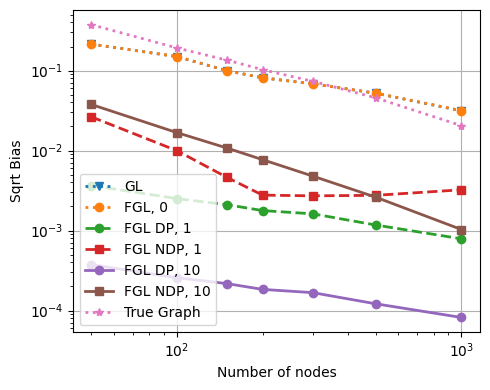

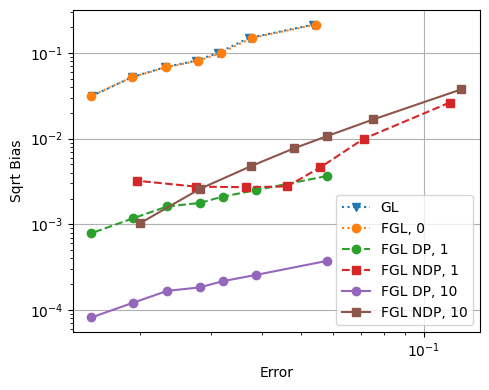

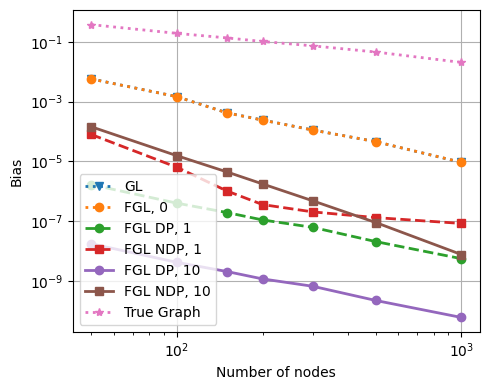

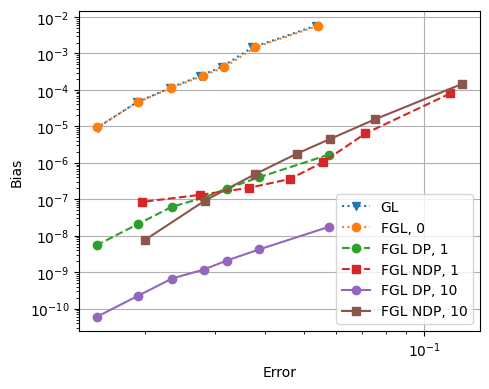

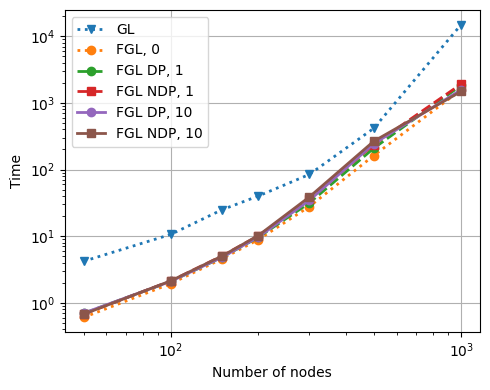

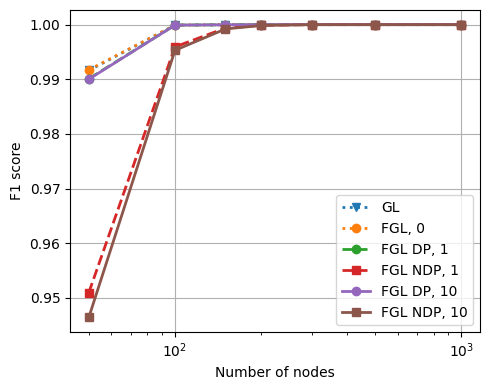

In [43]:
# Including bias from true graph
true_bias = compute_metric_err(Thetas_true, Thetas_true, 1, Zs=Zs, thr=.2, metric_type='bias')
true_sqrt_bias = compute_metric_err(Thetas_true, Thetas_true, 1, Zs=Zs, thr=.2, metric_type='sqrt-bias')
true_exp = {'fmt': '*:', 'leg': 'True Graph'}
Exps_aux =  Exps + [true_exp]
bias_aux = np.concatenate((bias, true_bias), axis=2)
sqrt_bias_aux = np.concatenate((sqrt_bias, true_bias), axis=2)

plt_args = { 'linewidth': 2 }
plot_results(DIM_RANGE, frob_err, Exps, y_label='Error', plt_args=plt_args, save=SAVE,
             file_name=f'{PATH}vardim_proj_plt_err')
plot_results(DIM_RANGE, sqrt_bias_aux, Exps_aux, y_label='Sqrt Bias', plt_args=plt_args, plot_f='loglog', 
             save=SAVE, file_name=f'{PATH}vardim_proj_plt_sqrtbias')
plot_err_bias_results(frob_err, sqrt_bias, Exps, plot_lines=True, y_label='Sqrt Bias', save=SAVE,
                      file_name=f'{PATH}vardim_proj_plt_err-sqrtbias')

plot_results(DIM_RANGE, bias_aux, Exps_aux, y_label='Bias', plt_args=plt_args, plot_f='loglog',
             save=SAVE, file_name=f'{PATH}vardim_proj_plt_bias')
plot_err_bias_results(frob_err, bias, Exps, plot_lines=True, save=SAVE,
                      file_name=f'{PATH}vardim_proj_plt_err-bias')

plot_results(DIM_RANGE, runingtimes, Exps, y_label='Time', plt_args=plt_args, plot_f='loglog', 
             save=SAVE, file_name=f'{PATH}vardim_proj_plt_time')
plot_results(DIM_RANGE, f1_score, Exps, y_label='F1 score', plt_args=plt_args)




In [ ]:
# # Load data
# file_name = PATH + 'vardim_graphs_v0'
# with open(file_name, 'rb') as f:
#     data = pickle.load(f)

# Exps = data['Exps']
# Thetas_est = data['Thetas_est']
# Thetas_true = data['Thetas_true']
# runingtimes = data['runingtimes']
# Zs = data['Zs']